In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter
import numpy as np
from sklearn.utils import resample
from lifelines import WeibullFitter
from lifelines import CoxPHFitter

In [10]:
df = pd.read_csv("Regn2004-2025.csv", sep=";")
df['Dato'] = pd.to_datetime(df['Dato'], format='%d.%m.%Y')
df_temp = pd.read_csv("Temperatur 2004-2025.csv", sep=";")
df_temp['Dato'] = pd.to_datetime(df_temp['Dato'], format='%d.%m.%Y')
df = df.merge(df_temp, on=['Dato', 'Tid'], how='left')


In [11]:
absorbtions = {'clay': 0.1, 'sand': 0.1, 'silt': 0.1, 'peat': 0.1, 'loam': 0.1}

df['prev_nedbor'] = df['Nedbor'].shift(1)

df['WOG_clay'] = df['Nedbor'] + df['prev_nedbor'] * absorbtions['clay'] # FORKERT!

df.dropna(inplace=True)

In [12]:
# lav en water at ground kollone og brug den (jordtype)

In [13]:
# Label dry spells (0 = dry, 1 = rain)
df["is_rain"] = (df["WOG_clay"] > 5).astype(int)

# Compute durations of dry spells
dry_spells = []
current_duration = 0
censored = False  # True if the last dry spell was ongoing at the end of the dataset
durations = []

for idx, row in df.iterrows():
    if row["is_rain"] == 0:
        current_duration += 1
    else:
        if current_duration > 0:
            dry_spells.append({"duration": current_duration, "observed": 1})
            current_duration = 0
    durations.append(current_duration)
# Handle censoring (if the dataset ends with a dry spell)
if current_duration > 0:
    dry_spells.append({"duration": current_duration, "observed": 0})

# Convert to DataFrame
dry_spell_df = pd.DataFrame(dry_spells)

df['duration'] = durations

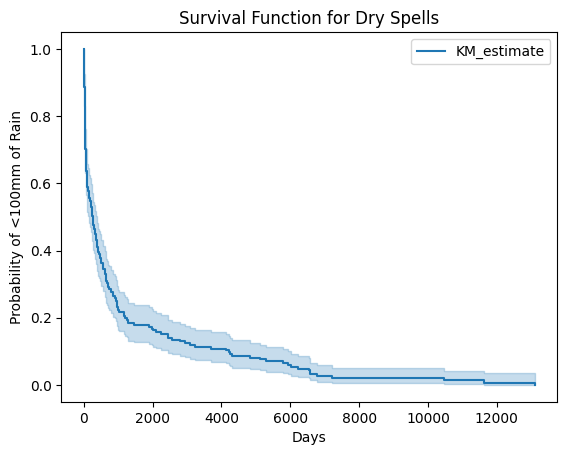

In [50]:
kmf = KaplanMeierFitter()
kmf.fit(durations=dry_spell_df["duration"], event_observed=dry_spell_df["observed"])

# Plot survival function with 95% confidence intervals
import matplotlib.pyplot as plt

kmf.plot_survival_function()
plt.title("Survival Function for Dry Spells")
plt.xlabel("Days")
plt.ylabel("Probability of <100mm of Rain")
plt.show()

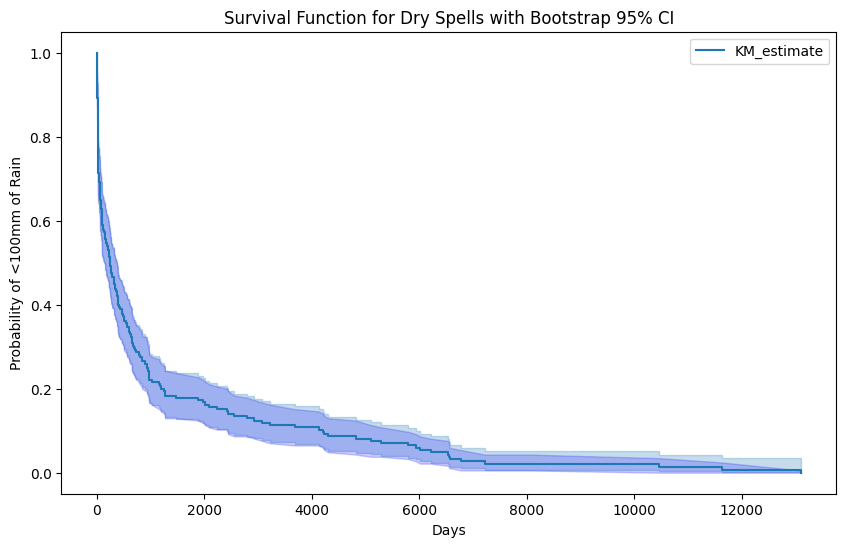

In [51]:
# First define a consistent timeline for all bootstrap samples
timeline = np.unique(dry_spell_df["duration"])  # Or use a predefined range

# Create empty list to store bootstrap results
bootstrap_estimates = []

# Run bootstrap
n_bootstraps = 1000
for i in range(n_bootstraps):
    # Sample with replacement
    bootstrap_sample = dry_spell_df.sample(n=len(dry_spell_df), replace=True)
    
    # Fit KM model
    kmf_boot = KaplanMeierFitter()
    kmf_boot.fit(durations=bootstrap_sample["duration"], 
                 event_observed=bootstrap_sample["observed"])
    
    # Get survival function at consistent timeline points
    survival_at_times = kmf_boot.survival_function_at_times(timeline)
    bootstrap_estimates.append(survival_at_times)

# Convert to numpy array (now all samples have same shape)
bootstrap_array = np.array(bootstrap_estimates)

# Compute 95% confidence intervals
lower_bound = np.percentile(bootstrap_array, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_array, 97.5, axis=0)

# Plot original curve with bootstrap confidence intervals
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

# Add bootstrap confidence intervals
plt.fill_between(timeline, lower_bound, upper_bound, alpha=0.2, color='blue')

plt.title("Survival Function for Dry Spells with Bootstrap 95% CI")
plt.xlabel("Days")
plt.ylabel("Probability of <100mm of Rain")
plt.show()

             coef  se(coef)  coef lower 95%  coef upper 95%  cmp to         z  \
lambda_  1.137556  0.048609        1.042285        1.232827     1.0  2.829871   
rho_     3.862826  0.359584        3.158054        4.567598     1.0  7.961493   

                    p   -log2(p)  
lambda_  4.656684e-03   7.746481  
rho_     1.699763e-15  49.063588  


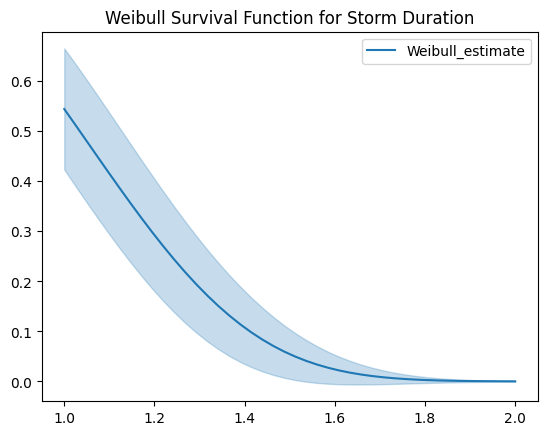

In [26]:
# Preprocess storm durations (similar to dry spells but for rain events)
storm_durations = []
current_duration = 0
censored = False

for idx, row in df.iterrows():
    if row["is_rain"] == 1:
        current_duration += 1
    else:
        if current_duration > 0:
            storm_durations.append({"duration": current_duration, "observed": 1})
            current_duration = 0
if current_duration > 0:
    storm_durations.append({"duration": current_duration, "observed": 0})

# Convert list of dictionaries to DataFrame
storm_df = pd.DataFrame(storm_durations)

# Now fit the Weibull model with proper data format
wf = WeibullFitter()
wf.fit(durations=storm_df["duration"], event_observed=storm_df["observed"])

print(wf.summary)  # Parameters (lambda, rho) with confidence intervals
wf.plot_survival_function()
plt.title("Weibull Survival Function for Storm Duration")
plt.show()

In [ ]:
# from lifelines import AalenAdditiveFitter
# Bayesian Deep Survival Models
# Spatial Survival
# from lifelines import CoxPHFitter


In [ ]:
# Aggregate data to daily level
daily_df = df.groupby("Dato")["Nedbor"].sum().reset_index()
daily_df["is_rain"] = (daily_df["Nedbor"] > 5).astype(int)

In [34]:
daily_df[daily_df['Nedbor'] >= 30].value_counts().sum()

np.int64(52)

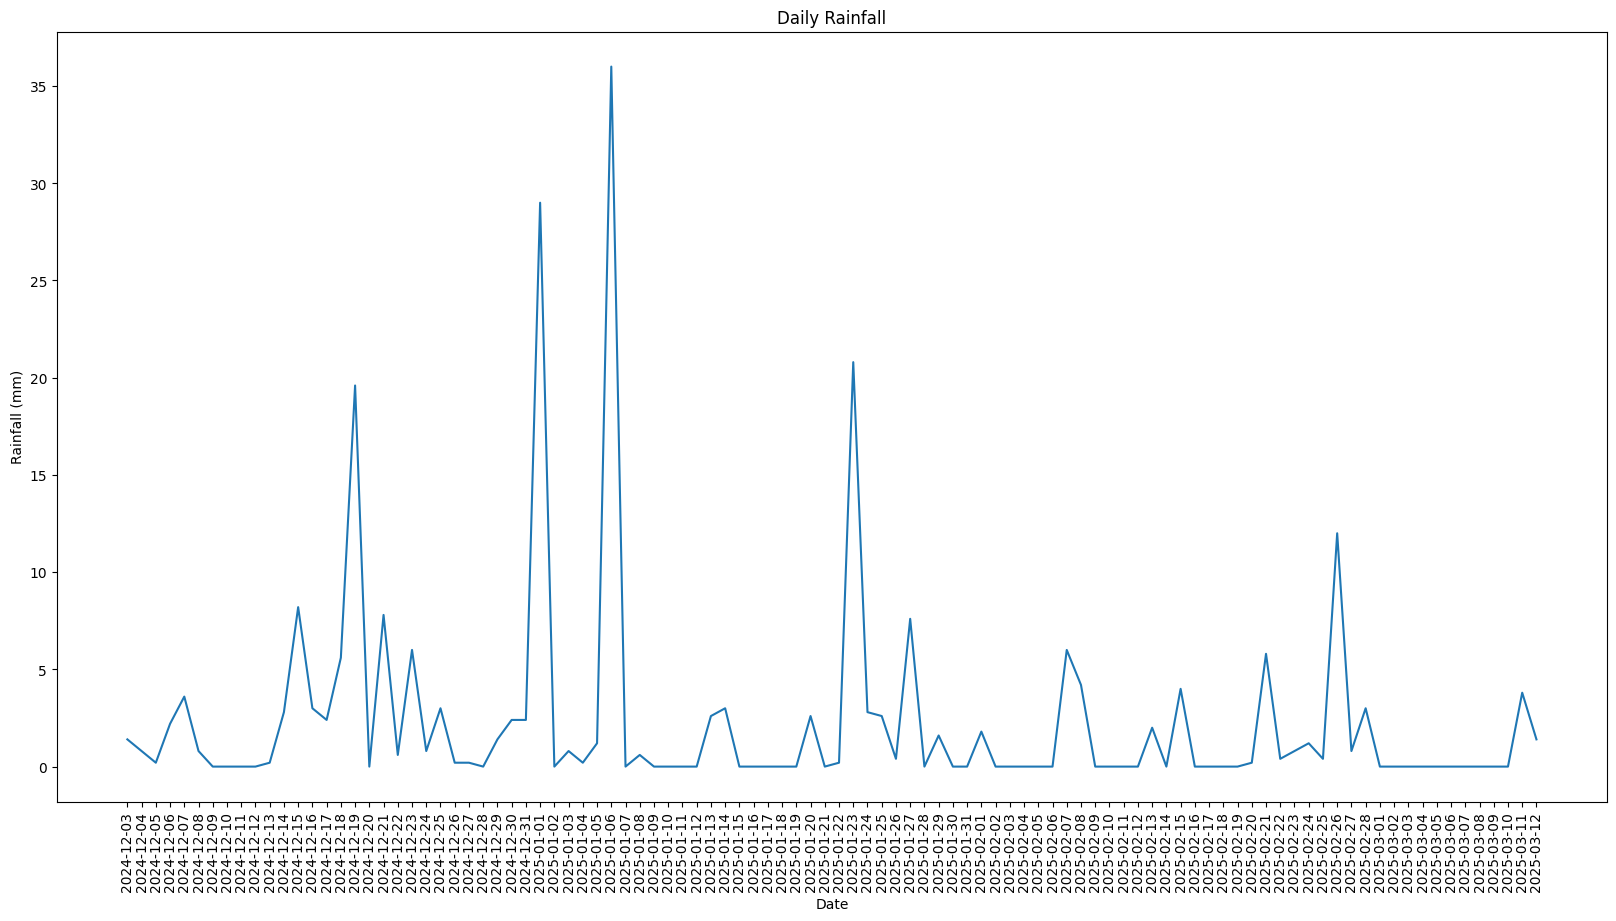

In [29]:
# make a scatter plot of the data with small dots and only for the last 100 days
plt.figure(figsize=(20, 10))
#plt.scatter(daily_df["Dato"][-100:], daily_df["Nedbor"][-100:], s=5)
plt.plot(daily_df["Dato"][-100:], daily_df["Nedbor"][-100:])

plt.title("Daily Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=90)
plt.show()